In [41]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 435.7 kB/s eta 0:04:47
   ---------------------------------------- 0.1/124.9 MB 1.0 MB/s eta 0:02:01
   ---------------------------------------- 0.3/124.9 MB 1.9 MB/s eta 0:01:06
   ---------------------------------------- 0.4/124.9 MB 2.1 MB/s eta 0:00:59
   ---------------------------------------- 0.5/124.9 MB 2.3 MB/s eta 0:00:56
   ---------------------------------------- 0.7/124.9 MB 2.4 MB/s eta 0:00:52
   ---------------------------------------- 0.9/124.9 MB 2.7 MB/s eta 0:00:46
   ---------------------------------------- 1.1/124.9 MB 2.9 MB/s eta 0:00:43
   ---------------------------------------- 1.3/124.9 MB 3.0 MB/s eta 0:00:42
   ---------------------------------------- 1.5/124.9 MB 3.2 MB/s eta 0:00:39
    --------------------------------------- 1.7/124.9 MB 3.5 MB/s eta 0:00:3

In [31]:
!pip install -U nltk



In [130]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.4 MB 991.0 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.4 MB 1.4 MB/s eta 0:00:01
   ------ --------------------------------- 0.2/1.4 MB 1.7 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.4 MB 2.1 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.4 MB 1.9 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.4 MB 2.1 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.4 MB 2.2 MB/s eta 0:00:01
   -------------------- ------------------- 0.7/1.4 MB 2.3 MB/s eta 0:00:01
   --------------------- ------------------ 0.8/1.4 MB 2.0 MB/s eta 0:00:01
   -------------------------- ------------- 0.9/1.4 MB 2.2 MB/s eta 0:00:01
   ------------------------------ --------- 1.1/1.4 MB 2.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.4 MB 2.3 MB/s eta 0:00:01
   --------------

In [138]:
!pip install catboost

In [124]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rroysuj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rroysuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rroysuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rroysuj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
dataset=pd.read_csv("C:/Users/rroysuj/Downloads/Restaurant_review_dataset/Restaurant_Reviews.tsv", delimiter='\t',quoting= 3)
dataset.head(10)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1


In [7]:
len(dataset)

1000

In [9]:
dataset.isnull().sum()

Review    0
Liked     0
dtype: int64

In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [12]:
processed_reviews = []
for review in dataset['Review']:
    review = re.sub('[^a-zA-Z!?.,]', ' ', review)
    words = review.lower().split()
    negative_words = {'no', 'not', 'never', 'neither', 'none', 'nobody'}
    cleaned_words = [lemmatizer.lemmatize(word) 
                    for word in words 
                    if word in negative_words or word not in stop_words]
    processed_reviews.append(' '.join(cleaned_words))

In [14]:
tfidf = TfidfVectorizer(
    max_features=6000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85,
    strip_accents='unicode',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,
    token_pattern=r'\b[a-zA-Z][a-zA-Z!?.,]+[a-zA-Z]\b'  # Include punctuation in tokens
)

In [15]:
X = tfidf.fit_transform(processed_reviews)
y = dataset['Liked']

In [16]:
exclamation_counts = np.array([review.count('!') for review in dataset['Review']]).reshape(-1, 1)
question_counts = np.array([review.count('?') for review in dataset['Review']]).reshape(-1, 1)

In [17]:
X_dense = np.hstack([X.toarray(), exclamation_counts, question_counts])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42
)

In [20]:
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)

In [21]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

In [22]:
nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=1000,
    random_state=42
)

In [23]:
lr_model = LogisticRegression(
    C=1.4,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

In [24]:
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=12,
    num_leaves=128,
    random_state=42,
    n_jobs=-1
)

In [25]:
catboost_model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.01,
    loss_function='Logloss',
    random_seed=42,
    verbose=False
)

In [26]:
adaboost_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)


In [27]:
estimators = [
    ('svm', svm_model),
    ('lr', lr_model)
]

In [28]:
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

Training Xgboost classifier...
Testing Xgboost classifier...
Accuracy Score: 0.76
Confusion Matrix
[[121  29]
 [ 43 107]]


<Axes: >

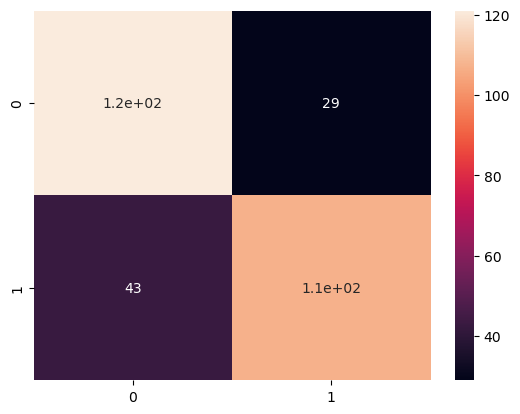

In [128]:
print("Training Xgboost classifier...")
xgboost_model=xgb_model.fit(X_train, y_train)
print("Testing Xgboost classifier...")
xgboost_y_pred = xgboost_model.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, xgboost_y_pred))
print("Confusion Matrix")
xgboost_cm = confusion_matrix(y_test, xgboost_y_pred)
print(xgboost_cm)
sns.heatmap(xgboost_cm , annot=True)

Training SVM classifier...
Testing SVM classifier...
Accuracy Score: 0.79
Confusion Matrix
[[119  31]
 [ 32 118]]


<Axes: >

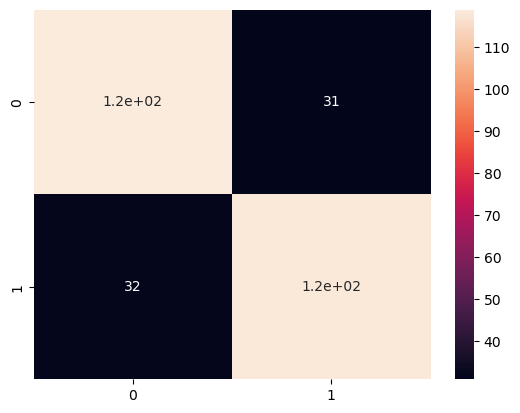

In [130]:
print("Training SVM classifier...")
svm=svm_model.fit(X_train, y_train)
print("Testing SVM classifier...")
svm_model_y_pred = svm.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, svm_model_y_pred))
print("Confusion Matrix")
svm_cm = confusion_matrix(y_test, svm_model_y_pred)
print(svm_cm)
sns.heatmap(svm_cm , annot=True)

Training RF classifier...
Testing RF classifier...
Accuracy Score: 0.7433333333333333
Confusion Matrix
[[119  31]
 [ 46 104]]


<Axes: >

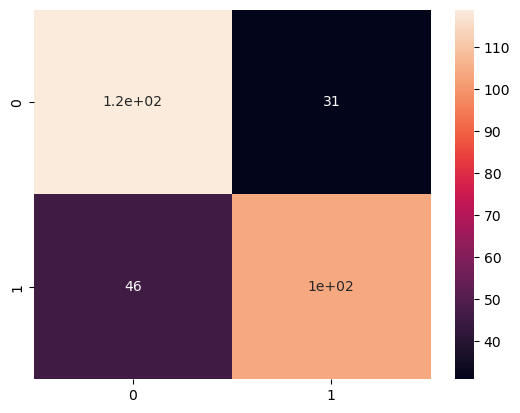

In [132]:
print("Training RF classifier...")
rf=rf_model.fit(X_train, y_train)
print("Testing RF classifier...")
rf_y_pred = rf.predict(X_test)
accuracy_score(y_test, rf_y_pred)
print("Accuracy Score:",accuracy_score(y_test, rf_y_pred))
print("Confusion Matrix")
rf_cm = confusion_matrix(y_test, rf_y_pred)
print(rf_cm)
sns.heatmap(rf_cm , annot=True)

Training NN classifier...
Testing NN classifier...
Accuracy Score: 0.7666666666666667
Confusion Matrix
[[110  40]
 [ 30 120]]


<Axes: >

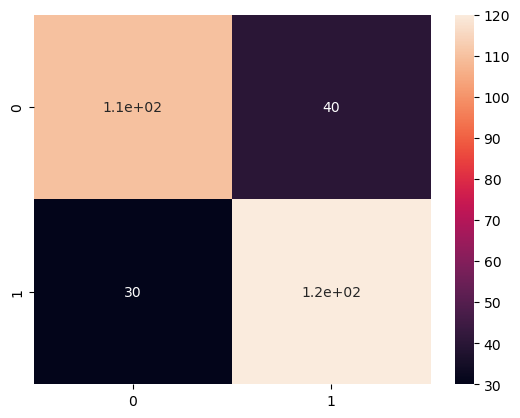

In [134]:
print("Training NN classifier...")
nn=nn_model.fit(X_train, y_train)
print("Testing NN classifier...")
nn_y_pred = nn.predict(X_test)
accuracy_score(y_test, nn_y_pred)
print("Accuracy Score:",accuracy_score(y_test, nn_y_pred))
print("Confusion Matrix")
nn_cm = confusion_matrix(y_test, nn_y_pred)
print(nn_cm)
sns.heatmap(nn_cm , annot=True)

In [33]:
print("Training LogR classifier...")
lr=lr_model.fit(X_train, y_train)
print("Testing LogR classifier...")
lr_y_pred = lr.predict(X_test)
accuracy_score(y_test, lr_y_pred)
print("Accuracy Score:",accuracy_score(y_test, lr_y_pred))
print("Confusion Matrix")
logr_cm = confusion_matrix(y_test, lr_y_pred)
print(logr_cm)
sns.heatmap(logr_cm , annot=True)

Training LogR classifier...
Testing LogR classifier...


0.845

Training LGBM classifier...
[LightGBM] [Info] Number of positive: 350, number of negative: 350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

<Axes: >

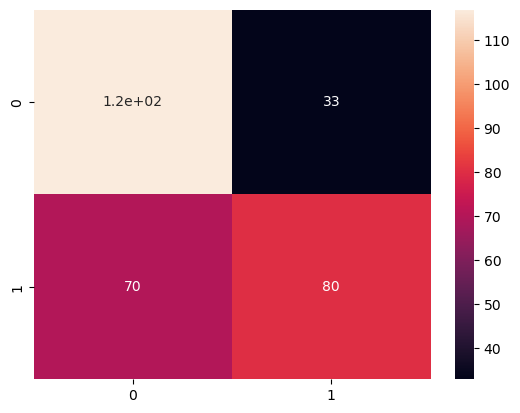

In [136]:
print("Training LGBM classifier...")
lgbm=lgbm_model.fit(X_train, y_train)
print("Testing LGBM classifier...")
lgbm_y_pred = lgbm.predict(X_test)
accuracy_score(y_test, lgbm_y_pred)
print("Accuracy Score:",accuracy_score(y_test, lgbm_y_pred))
print("Confusion Matrix")
lgbm_cm = confusion_matrix(y_test, lgbm_y_pred)
print(lgbm_cm)
sns.heatmap(lgbm_cm , annot=True)

Training CAT classifier...
Testing CAT classifier...
Accuracy Score: 0.7633333333333333
Confusion Matrix
[[126  24]
 [ 47 103]]


<Axes: >

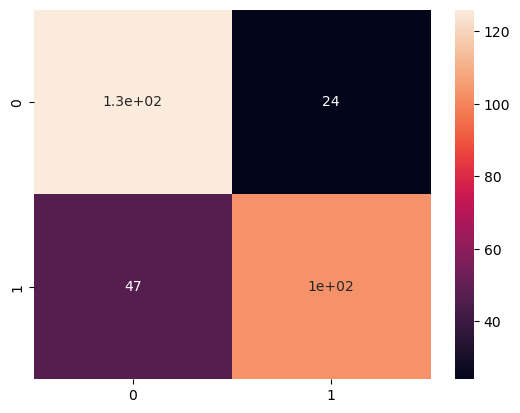

In [138]:
print("Training CAT classifier...")
cat=catboost_model.fit(X_train, y_train)
print("Testing CAT classifier...")
cat_y_pred = cat.predict(X_test)
accuracy_score(y_test, cat_y_pred)
print("Accuracy Score:",accuracy_score(y_test, cat_y_pred))
print("Confusion Matrix")
cat_cm = confusion_matrix(y_test, cat_y_pred)
print(cat_cm)
sns.heatmap(cat_cm , annot=True)

Training ADAboost classifier...


C:\Users\rroysuj\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Testing Adaboost classifier...
Accuracy Score: 0.72
Confusion Matrix
[[121  29]
 [ 55  95]]


<Axes: >

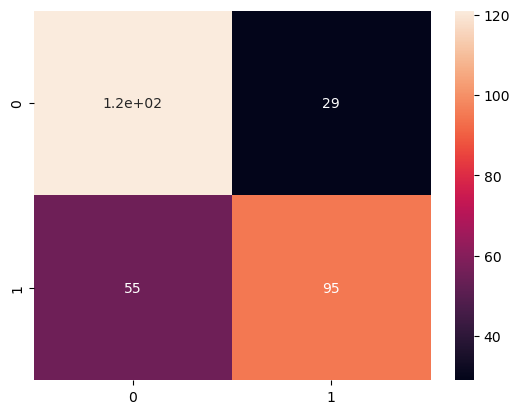

In [140]:
print("Training ADAboost classifier...")
ada=adaboost_model.fit(X_train, y_train)
print("Testing Adaboost classifier...")
ada_y_pred = ada.predict(X_test)
accuracy_score(y_test, ada_y_pred)
print("Accuracy Score:",accuracy_score(y_test, ada_y_pred))
print("Confusion Matrix")
adaboost_cm = confusion_matrix(y_test, ada_y_pred)
print(adaboost_cm)
sns.heatmap(adaboost_cm , annot=True)

In [44]:
print("Training stacking classifier...")
stacking_model.fit(X_train, y_train)

Training stacking classifier...


StackingClassifier(cv=5,
                   estimators=[('svm', SVC(probability=True, random_state=42)),
                               ('lr',
                                LogisticRegression(C=1.4,
                                                   class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [54]:
y_pred = stacking_model.predict(X_test)


In [55]:
print("\nStacking Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Stacking Classifier Results:
Accuracy: 0.8300

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       100
           1       0.80      0.88      0.84       100

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



In [56]:
!pip install tensorflow

In [433]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random
import os


In [435]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)  # For TF 2.7+
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

In [437]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, test_size=0.2, random_state=42, stratify=y
)

In [452]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')
])

C:\Users\rroysuj\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [454]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [456]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [458]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

In [459]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7843 - loss: 0.5230  

Test accuracy: 0.7700
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       100
           1       0.74      0.84      0.79       100

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_deep_nn():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [33]:
import re
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
from nltk.corpus import stopwords
corpus=[]
for i in range(0,1000):
  review=re.sub('[^a-zA-Z]',' ',dataset['Review'][i])
  review=review.lower()
  review=review.split()
  ps=PorterStemmer()
  review=[ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  review=' '.join(review)
  corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rroysuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: ylabel='count'>

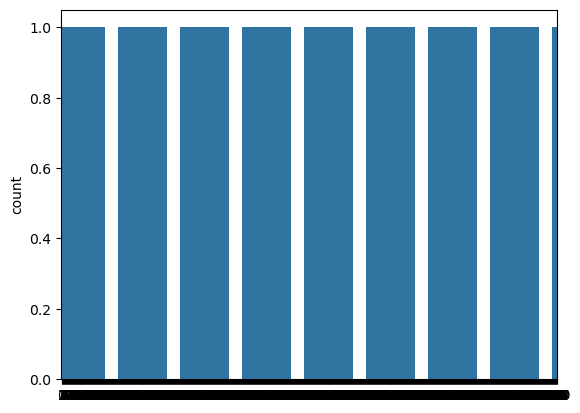

In [34]:
sns.countplot(dataset['Liked'])

In [ ]:
cv = CountVectorizer(max_features= 2000)
X= cv.fit_transform(dataset['Review']).toarray()
y=dataset['Liked']

In [27]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=4)

In [28]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(700, 2000) (700,) (300, 2000) (300,)


***Naive Bayes Model***
Accuracy Score: 73.67 %
Confusion Matrix
[[101  49]
 [ 30 120]]


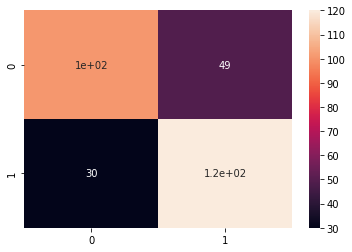

In [29]:
print("***Naive Bayes Model***")
gnb_model = GaussianNB()
gnb_model.fit(x_train,y_train)
y_pred = gnb_model.predict(x_test)
gnb_acc_score= accuracy_score(y_test,y_pred)
print("Accuracy Score:", round(gnb_acc_score * 100,2),"%")
print("Confusion Matrix")
gnb_cm = confusion_matrix(y_test, y_pred)
print(gnb_cm)
sns.heatmap(gnb_cm , annot=True)


***RandomForest Classifier Model***
Accuracy Score: 80.33 %
Confusion Matrix
[[124  26]
 [ 33 117]]


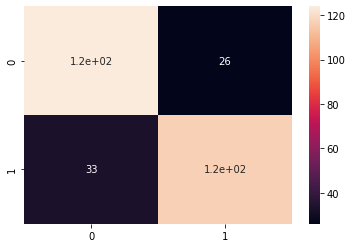

In [30]:
print("***RandomForest Classifier Model***")
rfc_model = RandomForestClassifier(n_estimators=1000,criterion='entropy')
rfc_model.fit(x_train,y_train)
y_pred = rfc_model.predict(x_test)
rfc_acc_score= accuracy_score(y_test,y_pred)
print("Accuracy Score:", round(rfc_acc_score * 100,2),"%")
print("Confusion Matrix")
rfc_cm = confusion_matrix(y_test, y_pred)
print(rfc_cm)
sns.heatmap(rfc_cm , annot=True)

***Logistic Regression Model***
Accuracy Score: 82.67 %
Confusion Matrix
[[121  29]
 [ 23 127]]


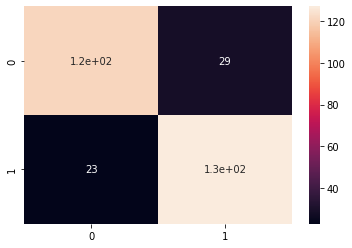

In [31]:
print("***Logistic Regression Model***")
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)
y_pred = lr_model.predict(x_test)
lr_acc_score= accuracy_score(y_test,y_pred)

print("Accuracy Score:", round(lr_acc_score * 100,2),"%")
print("Confusion Matrix")
lr_cm = confusion_matrix(y_test, y_pred)
print(lr_cm)
sns.heatmap(lr_cm , annot=True)

***GradientBoosting ClassifierModel***
Accuracy Score: 78.0 %
Confusion Matrix
[[134  16]
 [ 50 100]]


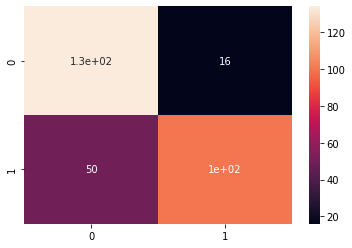

In [32]:
print("***GradientBoosting ClassifierModel***")
gb_model = GradientBoostingClassifier()
gb_model.fit(x_train,y_train)
y_pred = gb_model.predict(x_test)

gb_acc_score= accuracy_score(y_test,y_pred)
print("Accuracy Score:", round(gb_acc_score * 100,2),"%")
print("Confusion Matrix")
gb_cm = confusion_matrix(y_test, y_pred)
print(gb_cm)
sns.heatmap(gb_cm , annot=True)

In [33]:
data = {'Model':['Naive Bayes','RandomForest','Logistic Regression','GradientBoosting'],'Accuracy Score':[gnb_acc_score,rfc_acc_score,lr_acc_score,gb_acc_score]}

comparision_table=pd.DataFrame(data)                               
print(comparision_table)

                 Model  Accuracy Score
0          Naive Bayes        0.736667
1         RandomForest        0.803333
2  Logistic Regression        0.826667
3     GradientBoosting        0.780000


In [34]:
import joblib

In [35]:
filenamea="testmodela"

joblib.dump(gnb_model,filenamea)



['testmodela']

In [36]:
filenameb="testmodelb"
joblib.dump(rfc_model,filenameb)



['testmodelb']

In [37]:
filenamed="testmodelf"
joblib.dump(lr_model,filenamed)

['testmodelf']

In [38]:
filenamee="testmodele"
joblib.dump(gb_model,filenamee)

['testmodele']

#Prediction for new reviews using loaded_model1
###prediction for random review(Good) from dataset

In [223]:
dataset=pd.read_csv("/content/Restaurant_Reviews.tsv.tsv", delimiter='\t',quoting= 3)
#opening the dataset

In [224]:
new_review=dataset[dataset.Review=='The fries were great too.']["Review"]
#taking new random review from the dataset

In [225]:
old_review=dataset["Review"]
old_review.shape
#all old reviews from the dataset

(1000,)

In [226]:
data_for_preprocess=old_review.append(new_review)
data_for_preprocess.shape
#appending both reviews

(1001,)

In [227]:
data_for_preprocess.iloc[-1]

'The fries were great too.'

In [228]:
loaded_model1=joblib.load(filenamea)

cv_1 = CountVectorizer(max_features= 2000)
X_processed= cv_1.fit_transform(data_for_preprocess).toarray()
x_predd=X_processed[-1]
#converting categorical data to numerical data

In [229]:
X_processed[-1]

array([0, 0, 0, ..., 0, 0, 0])

In [231]:
x_predd = np.reshape(x_predd, (1,2000))
x_predd.shape
#converting 1D to 2D

(1, 2000)

In [239]:
out=loaded_model1.predict(x_predd) #Prediction for the new review
if(out[0]==0):
  print("Negative Review")
else:
  print("Positive Review")

Positive Review


In [240]:
type(data_for_preprocess)

pandas.core.series.Series

In [241]:
type(old_review)

pandas.core.series.Series

In [242]:
type(new_review)

pandas.core.series.Series

In [243]:
del new_review
del old_review
del data_for_preprocess
#deleting all Series

##Prediction for another new random review(Bad) from the existing data


In [244]:
dataset=pd.read_csv("/content/Restaurant_Reviews.tsv.tsv", delimiter='\t',quoting= 3)

In [245]:
new_review=dataset[dataset.Review=='Crust is not good.']["Review"]

In [246]:
old_review=dataset["Review"]

In [247]:
data_for_preprocess=old_review.append(new_review)

In [248]:
data_for_preprocess.iloc[-1]

'Crust is not good.'

In [249]:
loaded_model1=joblib.load(filenamea)

cv_1 = CountVectorizer(max_features= 2000)
X_processed= cv_1.fit_transform(data_for_preprocess).toarray()
x_predd=X_processed[-1]


In [250]:
X_processed[-1]

array([0, 0, 0, ..., 0, 0, 0])

In [251]:
x_predd = np.reshape(x_predd, (1,2000))
x_predd.shape

(1, 2000)

In [252]:
out1=loaded_model1.predict(x_predd)
if(out1[0]==0):
  print("Negative Review")
else:
  print("Positive Review")

Negative Review


In [253]:
del new_review
del old_review
del data_for_preprocess

##Prediction for Brand new Review(BAD) which is not there in the dataset

In [254]:
dataset=pd.read_csv("/content/Restaurant_Reviews.tsv.tsv", delimiter='\t',quoting= 3)

In [255]:
new_user_review=['Food was bad']
new_review=pd.Series(new_user_review)#converting the new review to series datatype

In [256]:
old_review=dataset["Review"]

In [257]:
new_review

0    Food was bad
dtype: object

In [258]:
data_for_preprocess=old_review.append(new_review)

In [259]:
data_for_preprocess.iloc[-1]

'Food was bad'

In [260]:
loaded_model1=joblib.load(filenamea)

cv_1 = CountVectorizer(max_features= 2000)
X_processed= cv_1.fit_transform(data_for_preprocess).toarray()
x_predd=X_processed[-1]


In [261]:
x_predd = np.reshape(x_predd, (1,2000))
x_predd.shape

(1, 2000)

In [263]:
out2=loaded_model1.predict(x_predd)
if(out2[0]==0):
  print("Negative Review")
else:
  print("Positive Review")

Negative Review


In [265]:
del new_review
del old_review
del data_for_preprocess

##Prediction for another brand new review(GOOD) which is not present in dataset


In [264]:
dataset=pd.read_csv("/content/Restaurant_Reviews.tsv.tsv", delimiter='\t',quoting= 3)

In [268]:
new_user_review=['good service']
new_review=pd.Series(new_user_review)#converting the new review to series datatype

In [270]:
new_review

0    good service
dtype: object

In [269]:
old_review=dataset["Review"]

In [271]:
data_for_preprocess=old_review.append(new_review)

In [272]:
data_for_preprocess.iloc[-1]

'good service'

In [273]:
loaded_model1=joblib.load(filenamea)

cv_1 = CountVectorizer(max_features= 2000)
X_processed= cv_1.fit_transform(data_for_preprocess).toarray()
x_predd=X_processed[-1]

In [274]:
x_predd = np.reshape(x_predd, (1,2000))
x_predd.shape

(1, 2000)

In [276]:
out3=loaded_model1.predict(x_predd)
if(out3[0]==0):
  print("Negative Review")
else:
  print("Positive Review")

Positive Review
